In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
%matplotlib inline

In [74]:
class simulation:
    def __init__(self, file):
        self.d = np.genfromtxt(file)
    #     gal_id = d[:,0]
        self.zt = self.d[:,1]
        self.zph= self.d[:,2]
    #     zph_err = d[:,3]
        self.Ngal = self.zt.size
        
    def plot_scatter(self, fig_file=None):
        plt.figure(figsize=(8,8))
        plt.scatter(self.zph, self.zt, s=0.05, c='red')
        plt.plot(self.zph, self.zph+3*0.05*(1+self.zph), color='black' )
        plt.plot(self.zph, self.zph-3*0.05*(1+self.zph), color='black' )
        plt.xlim(0,3.5)
        plt.ylim(0,3.5)
        plt.ylabel(r'$z_{\rm true}$')
        plt.xlabel(r'$z_{\rm ph}$')
        if fig_file is not None:
            plt.savefig(fig_file)
        plt.show()
    
    def get_stochastic_mat(self, mat_file=None):
        dz = 0.05
        self.dz = dz
        zmax = 3.5
        zph_delims = np.arange(0.0, zmax, dz)
        Nph = zph_delims.size
        self.Nph = Nph
        print('z_ph bins:', zph_delims, Nph)

        mat = np.int_(np.zeros((Nph,Nph))) # Ngal mixture matrix
        mat_norm = np.zeros((Nph,Nph)) # Ngal mixture matrix
        Nx = np.int_(np.zeros(Nph)) # Ngal in each z_ph bin
        ix = np.int_(np.floor(self.zph/dz))
        iy = np.int_(np.floor(self.zt/dz))
        ix[ix>Nph]=Nph # gals with z>3.45 are all assigned into Nph-th bin
        iy[iy>Nph]=Nph
        for i in range(self.Ngal):
            Nx[ix[i]] += 1
            mat[ix[i]][iy[i]] += 1

        print("bin index of each z_ph: ix:", ix)
        print('Ngal in each z_ph bin: Nx =', Nx)
        print('Unnormalized matrix:', mat)

        for i in range(Nph):
            mat_norm[i] = mat[i]/float(Nx[i])
        print('Stochastic matrix:', mat_norm)

        if mat_file is not None:
            np.savetxt(mat_file, mat_norm)
            print('matrix saved.')
        return mat_norm
    
    def get_stochastic_mat_ext(self, mat_file=None):
        dz = 0.05
        self.dz = dz
        zmax = 3.5
        zph_delims = np.arange(0.0, zmax, dz)
        Nph = zph_delims.size
        self.Nph = Nph
        print('z_ph bins:', zph_delims, Nph)

        mat = np.int_(np.zeros((Nph,Nph))) # Ngal mixture matrix
        mat_norm = np.zeros((Nph,Nph)) # mixture probability matrix
        Nx = np.int_(np.zeros(Nph)) # Ngal in each z_ph bin
        ix = np.int_(np.floor(self.zph/dz))
        zt_nogauss = self.zt
        ind_gauss = (np.absolute(self.zt-self.zph)/(1.+self.zph)<=0.05*3)
        zt_nogauss[ind_gauss] = self.zph[ind_gauss]
        iy = np.int_(np.floor(zt_nogauss/dz))
        ix[ix>Nph]=Nph # gals with z>3.45 are all assigned into Nph-th bin
        iy[iy>Nph]=Nph
        for i in range(self.Ngal):
            Nx[ix[i]] += 1
            mat[ix[i]][iy[i]] += 1

        print("bin index of each z_ph: ix:", ix)
        print('Ngal in each z_ph bin: Nx =', Nx)
        print('Unnormalized matrix:', mat)

        for i in range(Nph):
            mat_norm[i] = mat[i]/float(Nx[i])
        print('Stochastic matrix:', mat_norm)

        if mat_file is not None:
            np.savetxt(mat_file, mat_norm)
            print('matrix saved.')
        return mat_norm 
    
    def plot_mat_norm(self, mat_norm, fig_file=None):
        fig,ax=plt.subplots(1,1,figsize=(10,10))
        img = ax.imshow(mat_norm.T, origin='lower')
        ticks = np.arange(-0.5,self.Nph,10)
        ticklabels = ["{:6.1f}".format(i) for i in self.dz*(ticks+0.5)]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels)
        ax.set_xlabel(r'$z_{\rm ph}$')
        ax.set_ylabel(r'$z_{\rm true}$')
        fig.colorbar(img)
        if fig_file is not None:
            plt.savefig(fig_file)
            print('figure saved.')
        plt.show()
    
    def convert_nz(self, mat_norm, toconvert_files, out_nzfile_suffix = None):
        for toconvert_file1 in toconvert_files:
            d1 = np.loadtxt(toconvert_file1)
            z = d1[:,1]
            nz_old = d1[:,3]
            ix_z = np.int_(np.floor(z/self.dz))
            prefactor = np.int_(np.zeros(self.Nph))
            for i in range(z.size):
                prefactor[ix_z[i]] += 1

            nz_new = np.zeros(z.size)
            for i in range(z.size):
                for j in range(z.size):
                    nz_new[i] += mat_norm[ix_z[j]][ix_z[i]] * nz_old[j]
                nz_new[i] /= prefactor[ix_z[i]]
            if out_nzfile_suffix is not None:
                outfile = toconvert_file1 + out_nzfile_suffix
            else:
                outfile = toconvert_file1+'new'
            np.savetxt(outfile, np.c_[d1[:,0],d1[:,1],d1[:,2],nz_new])
            print('new nz saved.')
            plt.plot(z, nz_old, '--')
            plt.plot(z, nz_new)
            plt.xlabel(r'$z$')
            plt.ylabel(r'$n(z)$')
            plt.show()

    def convert_nz_ext(self, mat_norm, toconvert_files, out_nzfile_suffix = None):
        mat_norm_diag = np.diag(mat_norm) # extract diagonal elements, i.e. autobin mapping fraction
        mat_norm_ext = mat_norm - np.diag(mat_norm_diag) # remove diagonal elements
        for toconvert_file1 in toconvert_files:
            d1 = np.loadtxt(toconvert_file1)
            z = d1[:,1]
            nz_old = d1[:,3]
            ix_z = np.int_(np.floor(z/self.dz))
            prefactor = np.int_(np.zeros(self.Nph))
            for i in range(z.size):
                prefactor[ix_z[i]] += 1
            
            nz_old_binned = []
            n_per_bin = np.sum(nz_old)/10.
            nz_cumsum = np.cumsum(nz_old)
            nz_bin_z_ind = [0]
            for i in range(9):
                nz_bin_z_ind.append((np.where(nz_cumsum <= n_per_bin*(i+1))[0])[-1])
            for i in range(9):
                nz_old_binned.append(np.zeros(nz_old.size))
                nz_old_binned[i][nz_bin_z_ind[i]:nz_bin_z_ind[i+1]]= nz_old[nz_bin_z_ind[i]:nz_bin_z_ind[i+1]]
            nz_old_binned.append(np.zeros(nz_old.size))
            nz_old_binned[9][nz_bin_z_ind[9]:] = nz_old[nz_bin_z_ind[9]:]
    
            nz_new_ext = np.zeros(z.size) # extreme outlier part
            nz_new_diag = np.zeros(z.size) # central diagonal part
        
            nz_new_ext_binned = []
            for i in range(10):
                nz_new_ext_binned.append(np.zeros(z.size))
            
            for i in range(z.size):
                norm = 0
                for j in range(z.size):
                    nz_new_ext[i] += mat_norm_ext[ix_z[j]][ix_z[i]] * nz_old[j]
                nz_new_ext[i] /= prefactor[ix_z[i]]
                nz_new_diag[i] = mat_norm_diag[ix_z[i]] * nz_old[i] # add back diagonal contribution
            print('sum of nz_old = %le'%((np.sum(nz_old))))
            print('sum of nz_new = %le, nz_new_ext = %le, nz_new_diag = %le'
                  %(np.sum(nz_new_ext+nz_new_diag),np.sum(nz_new_ext),np.sum(nz_new_diag)) )

            for i_tomobin in range(10):
                for i in range(z.size):
                    norm = 0
                    for j in range(z.size):
                        nz_new_ext_binned[i_tomobin][i] += mat_norm_ext[ix_z[j]][ix_z[i]] * nz_old_binned[i_tomobin][j]
                    nz_new_ext_binned[i_tomobin][i] /= prefactor[ix_z[i]]
            
            if out_nzfile_suffix is not None:
                outfile = toconvert_file1 + out_nzfile_suffix
            else:
                outfile = toconvert_file1+'new'
            outlist = [d1[:,0],d1[:,1],d1[:,2],nz_old,nz_new_diag,nz_new_ext]
            np.savetxt(outfile, np.c_[d1[:,0],d1[:,1],d1[:,2],nz_old,nz_new_diag,nz_new_ext,
                                      nz_new_ext_binned[0],nz_new_ext_binned[1],nz_new_ext_binned[2],
                                      nz_new_ext_binned[3],nz_new_ext_binned[4],nz_new_ext_binned[5],
                                      nz_new_ext_binned[6],nz_new_ext_binned[7],nz_new_ext_binned[8],
                                      nz_new_ext_binned[9] ])
            print('new nz saved.')
            plt.plot(z, nz_old, '--')
            plt.plot(z, nz_new_diag+nz_new_ext)
            plt.plot(z, nz_new_diag, '-.')
            plt.plot(z, nz_new_ext, '-.')
            for i in range(10):
                plt.plot(z, nz_new_ext_binned[i], '.')
            plt.xlabel(r'$z$')
            plt.ylabel(r'$n(z)$')
            plt.show()

In [75]:
simfile = 'Graham20/LSSTyear2_noEuclid.zphot'
mat_file = simfile[:-6]+'_mat.txt'
toconvert_files = ['../zdistris/lens_LSSTY1', '../zdistris/src_LSSTY1']

In [76]:
simY2 = simulation(simfile)

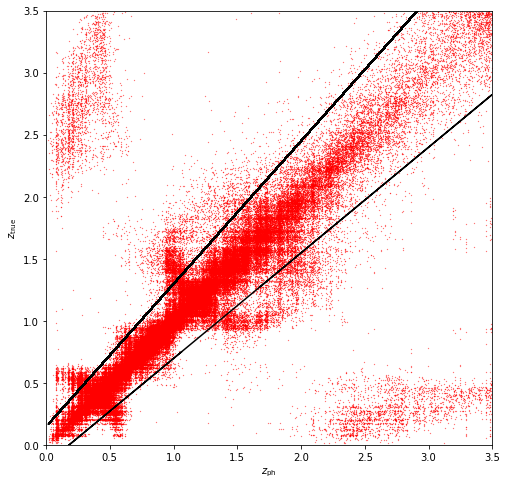

z_ph bins: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45] 70
bin index of each z_ph: ix: [21  5 18 ... 19 15 33]
Ngal in each z_ph bin: Nx = [   79  1407   936  1628  3740  6182  5034  3744  6298  8279  6922  8129
 10104  6554  6216  7847  7276  4897  6458  7259  4996  4414  3786  3312
  3281  3427  3278  2102  3363  2747  2101  2477  1414  2331  2086  1187
  1755  1348  1398  1365   904  1013   767   647   892   698   602   592
   628   557   512   342   428   423   430   435   317   234   308   280
   298   186   221   274   210   210   214   218   221   319]
Unnormalized matrix: [[ 14  25   4 ...   0   0   0]
 [ 31 690 148 ...   0   0   0]
 [  1 126 282 ...   0   0   0]
 ...
 [  

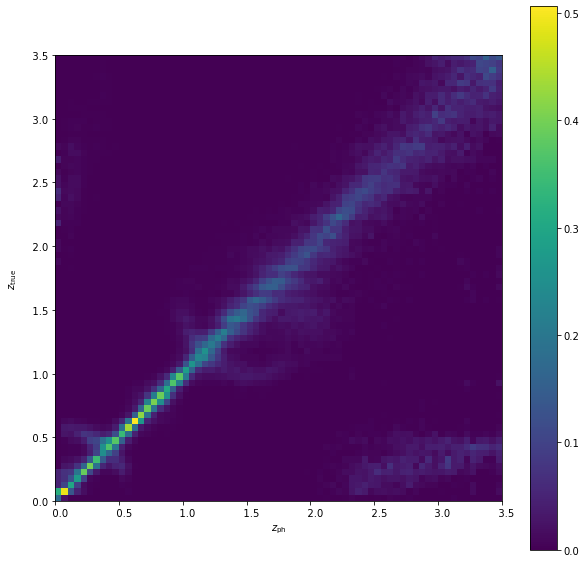

new nz saved.


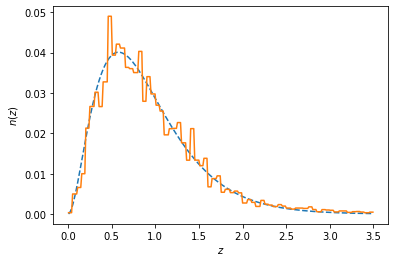

new nz saved.


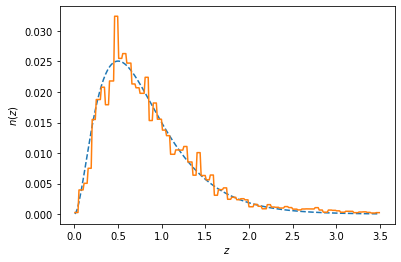

z_ph bins: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45] 70
bin index of each z_ph: ix: [21  5 18 ... 19 15 33]
Ngal in each z_ph bin: Nx = [   79  1407   936  1628  3740  6182  5034  3744  6298  8279  6922  8129
 10104  6554  6216  7847  7276  4897  6458  7259  4996  4414  3786  3312
  3281  3427  3278  2102  3363  2747  2101  2477  1414  2331  2086  1187
  1755  1348  1398  1365   904  1013   767   647   892   698   602   592
   628   557   512   342   428   423   430   435   317   234   308   280
   298   186   221   274   210   210   214   218   221   319]
Unnormalized matrix: [[  46    0    0 ...    0    0    0]
 [   0 1067    0 ...    0    0    0]
 [   0    0  638 ...    0   

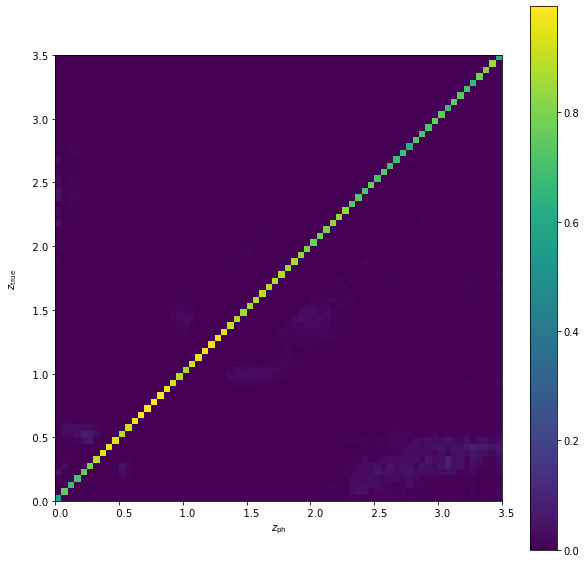

sum of nz_old = 3.827451e+00
sum of nz_new = 3.827451e+00, nz_new_ext = 3.426906e-01, nz_new_diag = 3.484761e+00
new nz saved.


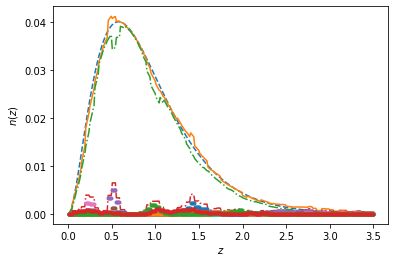

sum of nz_old = 2.190543e+00
sum of nz_new = 2.190543e+00, nz_new_ext = 2.009463e-01, nz_new_diag = 1.989597e+00
new nz saved.


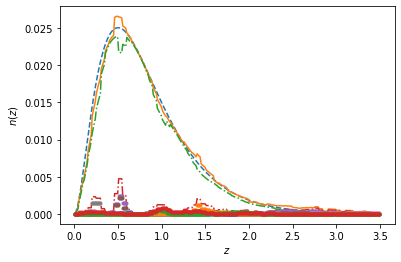

In [77]:
simY2.plot_scatter()
mat_norm = simY2.get_stochastic_mat(mat_file=mat_file)
simY2.plot_mat_norm(mat_norm)
simY2.convert_nz(mat_norm,toconvert_files)
mat_norm_ext = simY2.get_stochastic_mat_ext(mat_file=mat_file[:-4]+'_ext.txt')
simY2.plot_mat_norm(mat_norm_ext)
simY2.convert_nz_ext(mat_norm_ext,toconvert_files,'ext')

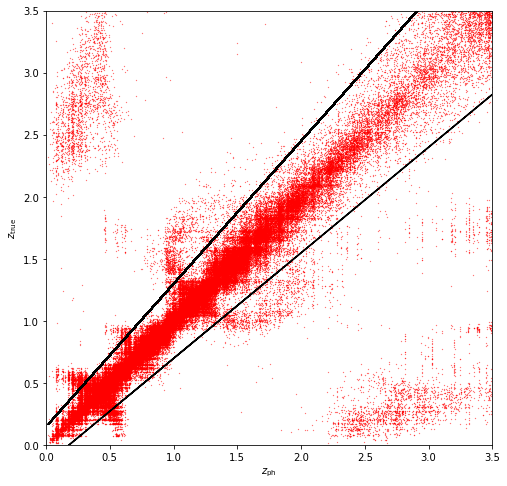

z_ph bins: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45] 70
bin index of each z_ph: ix: [36  7 19 ... 10 19 10]
Ngal in each z_ph bin: Nx = [   78  1387   906  1494  3807  6255  5047  4032  6602  8720  7496  8596
 10687  6714  6382  8040  7576  4851  6304  7261  4784  4308  3812  3323
  3193  3629  3614  2390  3762  3084  2135  2609  1317  2144  1924  1103
  1610  1080  1258  1206   808   802   685   527   837   668   545   545
   643   508   464   312   459   457   471   496   377   284   387   388
   357   266   285   361   236   247   346   297   228   462]
Unnormalized matrix: [[ 25  28   4 ...   1   0   0]
 [ 33 870 172 ...   0   0   0]
 [  2 101 371 ...   0   0   0]
 ...
 [  

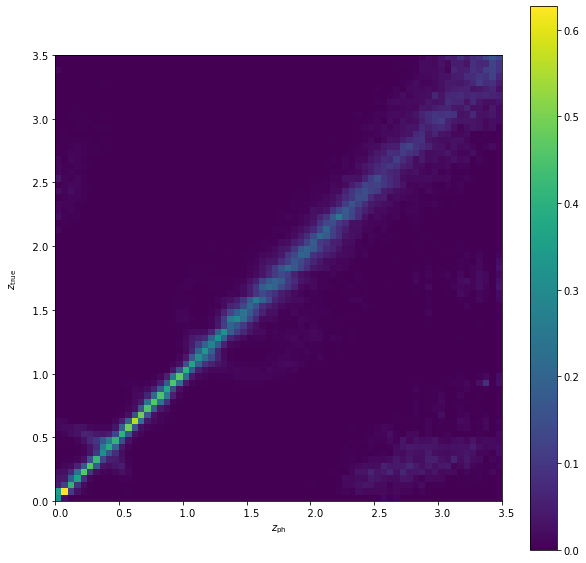

new nz saved.


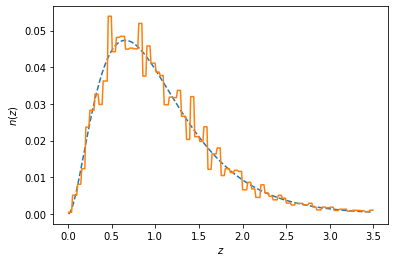

new nz saved.


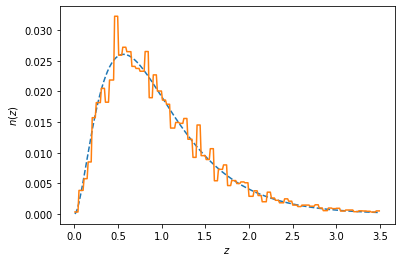

z_ph bins: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45] 70
bin index of each z_ph: ix: [36  7 19 ... 10 19 10]
Ngal in each z_ph bin: Nx = [   78  1387   906  1494  3807  6255  5047  4032  6602  8720  7496  8596
 10687  6714  6382  8040  7576  4851  6304  7261  4784  4308  3812  3323
  3193  3629  3614  2390  3762  3084  2135  2609  1317  2144  1924  1103
  1610  1080  1258  1206   808   802   685   527   837   668   545   545
   643   508   464   312   459   457   471   496   377   284   387   388
   357   266   285   361   236   247   346   297   228   462]
Unnormalized matrix: [[  59    0    0 ...    1    0    0]
 [   0 1171    0 ...    0    0    0]
 [   0    0  722 ...    0   

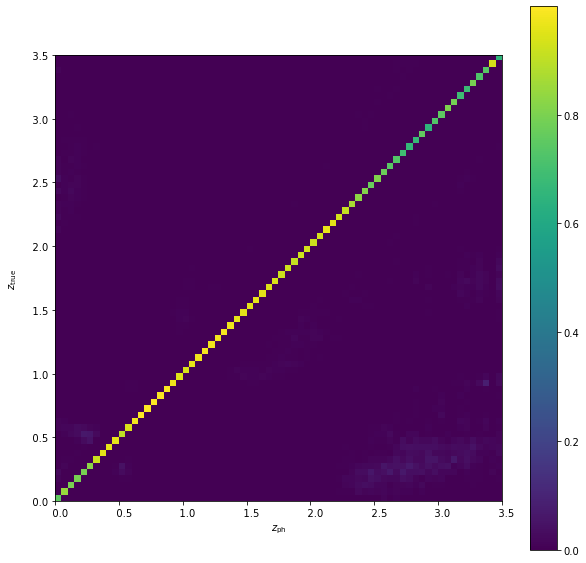

sum of nz_old = 5.242817e+00
sum of nz_new = 5.242817e+00, nz_new_ext = 2.850180e-01, nz_new_diag = 4.957799e+00
new nz saved.


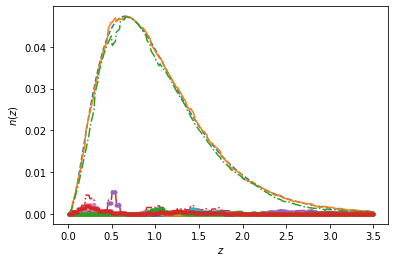

sum of nz_old = 2.715959e+00
sum of nz_new = 2.715959e+00, nz_new_ext = 1.558192e-01, nz_new_diag = 2.560140e+00
new nz saved.


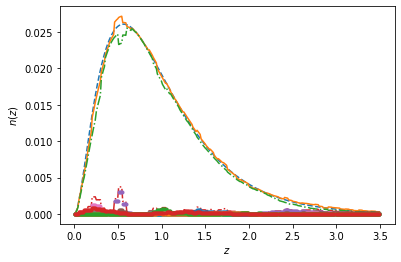

In [78]:
simfile = 'Graham20/LSSTyear5_noEuclid.zphot'
mat_file = simfile[:-6]+'_mat.txt'
toconvert_files = ['../zdistris/lens_LSSTY6', '../zdistris/src_LSSTY6']
simY6 = simulation(simfile)
simY6.plot_scatter()
mat_normY6 = simY6.get_stochastic_mat(mat_file=mat_file)
simY6.plot_mat_norm(mat_normY6)
simY6.convert_nz(mat_normY6,toconvert_files)

mat_norm_extY6 = simY6.get_stochastic_mat_ext(mat_file=mat_file[:-4]+'_ext.txt')
simY6.plot_mat_norm(mat_norm_extY6)
simY6.convert_nz_ext(mat_norm_extY6,toconvert_files,'ext')